In [1]:
# Import statements
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Display options
pd.set_option('display.max_columns', None)

In [2]:
hr_employee = pd.read_csv( './Data/HR_Employee.csv', delimiter = ",")
Attrition = pd.read_csv( './Data/Attrition.csv', delimiter = ",")

In [3]:
X = hr_employee
# Y = Attrition.values.ravel()
Y = Attrition

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1176, 69) (1176, 1)
(294, 69) (294, 1)


#### Functions

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
# Function:    gridSearcBestEstimator
# Input:       Classifier, parameters, cross validation
# Output:      Prints Best Estimator
# Returns:     Best Estimator
def gridSearcBestEstimator(model, params, cv):
    clf = model 
    gs = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', cv=cv, n_jobs=-1, )

    gs.fit(X_train, y_train.values.ravel())
    best_estimator = gs.best_estimator_
    
    print('Best Estimator:')
    print(best_estimator,'\n')
    
    #if model == DecisionTreeClassifier():
    #    best_estimator.get_depth()

    return best_estimator

In [6]:
# Function:    fitModel
# Input:       Classifier
# Returns:     Fitted Model
def fitModel(model):
    clf = model
    clf.fit(X_train, y_train.values.ravel())
    
    return clf

In [7]:
from sklearn.metrics import accuracy_score
# Function:    modelAccuracy
# Input:       Classifier with Best Estimator
# Output:      Prints Training & Testing Accuracy
# Returns:     Y Test Predictions
def modelAccuracy(model):
    clf = model
    
    # Make Train predictions
    y_train_pred = clf.predict(X_train)
    # Calculate accuracy score
    training_accuracy = accuracy_score(y_train, y_train_pred)
    print('Training Accuracy: ',training_accuracy)
    # confusionMatrixMetrics(y_train, y_pred)

    # Make Test predictions
    y_test_pred = clf.predict(X_test)
    # Calculate accuracy scores
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    print('Testing Accuracy:  ',testing_accuracy)
    
    return y_test_pred

In [8]:
from sklearn.metrics import confusion_matrix
# Function:    confusionMatrix
# Input:       Training/Testing dataframe and predictions
# Output:      Prints Formatted Confusion Matrix
# Returns:     Confusion Matrix Array
# URL:         https://towardsdatascience.com/evaluating-machine-learning-classification-problems-in-python-5-1-metrics-that-matter-792c6faddf5
def confusionMatrix(true_test_train, pred):
    true = true_test_train
    
    cm = confusion_matrix(true, pred.round(), normalize=None)

    # Assigning columns names
    cm_df = pd.DataFrame(cm, 
                        columns = ['Predicted Negative', 'Predicted Positive'],
                        index = ['Actual Negative', 'Actual Positive'])
    
    # Printing Formatted Confusion Matrix
    print('\n',cm_df)
    
    return cm

In [9]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
# Function:    metrics
# Input:       confusion matrix array, true class values, predicted class values
# Output:      Prints Recall, Sensitivity, Precision, False Positive Rate, Balanced Accuracy & F1 Scores
def metrics(cm, true, pred):
    # Assign values from the confusion matrix to manually 
    # calculate Specificity and False Positive Rate 
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]

    # Recall
    recall = recall_score(true, pred)
    print('\nRecall:                  ', recall)
    # Sensitivity
    sensitivity = recall
    # Specificity
    specificity = (TN / float(TN + FP))
    print('Specificity:             ', specificity)
    # Precision
    precision = precision_score(true, pred)
    print('Precision:               ', precision)
    # False Positive Rate
    # fpr = (FP / float(TN + FP))
    # print ('False Positive Rate:     ', fpr)
    # Balanced Accuracy
    balanced_accuracy = (sensitivity + specificity)/2
    #balance_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    print('Balanced Accuracy:       ', balanced_accuracy)
    # F1 Score Method 1: sklearn
    F1 = f1_score(true, pred)
    print('F1-Score:                ', F1)
    
    #return recall, specificity, precision, balanced_accuracy, F1, cm_df

### Logistic Regression Pre-processing
Scale Data

In [10]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Performance on default logistic regression model

In [11]:
# Fit Model to Default Classifier
lr_clf = fitModel(LogisticRegression())

# Calcualate Training and Testing Accuracy
y_test_pred = modelAccuracy(lr_clf)

# Print Confusion Matrix
cm = confusionMatrix(y_test, y_test_pred)

# Print Metrics
metrics(cm, y_test, y_test_pred)

Training Accuracy:  0.8886054421768708
Testing Accuracy:   0.891156462585034

                  Predicted Negative  Predicted Positive
Actual Negative                 243                   7
Actual Positive                  25                  19

Recall:                   0.4318181818181818
Specificity:              0.972
Precision:                0.7307692307692307
Balanced Accuracy:        0.7019090909090909
F1-Score:                 0.5428571428571428


#### Confusion Matrix for default model

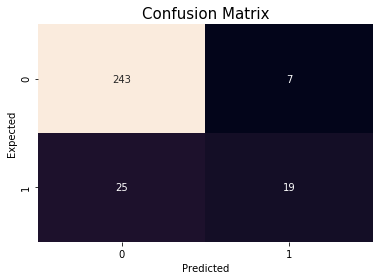

In [12]:
# Confusion Matrix
cm_plot =  pd.crosstab(index=y_test.values.ravel(), columns=y_test_pred, rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(cm_plot, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

### Cross Validation Setup

In [13]:
# Cross Validate
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

### GridSearch CV Logistic Regression

In [14]:
# Determine Best Estimator
params = dict(
    penalty = ['l1','l2'], #l1 lasso l2 ridge
    C = np.logspace(-3,3,7),
    solver=['lbfgs'],
    max_iter = [200,250,500,750]
)

# best_estimator = GridSearchCV(lr_clf, params,cv=10)
best_estimator = gridSearcBestEstimator(LogisticRegression(), params, cv)

# # Fit Model to best_estimator
lr_clf = fitModel(best_estimator)

# Calcualate Training and Testing Accuracy
y_test_pred = modelAccuracy(lr_clf)

# Print Confusion Matrix
cm = confusionMatrix(y_test, y_test_pred)

# Print Metrics
metrics(cm, y_test, y_test_pred)

Best Estimator:
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Training Accuracy:  0.8869047619047619
Testing Accuracy:   0.8945578231292517

                  Predicted Negative  Predicted Positive
Actual Negative                 240                  10
Actual Positive                  21                  23

Recall:                   0.5227272727272727
Specificity:              0.96
Precision:                0.696969696969697
Balanced Accuracy:        0.7413636363636363
F1-Score:                 0.5974025974025974


### Confusion Matrix for Best Estimator

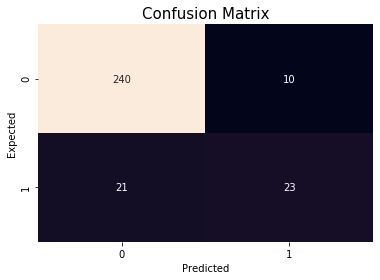

In [15]:
# Confusion Matrix
cm_plot =  pd.crosstab(index=y_test.values.ravel(), columns=y_test_pred, rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(cm_plot, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

### Observations
The base logistic regression model performed well with default parameters. Training accuracy was 90% and testing accuracy was 85%. Through grid search, the best model chosen performed at this same accuracy. 


## Running model on subset of data to see if performance improves. This approach will be for:
1) high/low monthly rate (proxy for income),

2) male/female employees

In [16]:
# find median MonthlyRate
import statistics
median_monthRate = statistics.median(X['MonthlyRate'])
median_monthRate

0.48751254768118846

In [17]:
# Use Median to create split for high/low variable
X_high = X.loc[X['MonthlyRate'] > median_monthRate]
Y_high = Y.loc[X['MonthlyRate'] > median_monthRate]
X_low = X.loc[X['MonthlyRate'] <= median_monthRate]
Y_low = Y.loc[X['MonthlyRate'] <= median_monthRate]

In [18]:
print(Y_low.shape)
print(X_low.shape)
print(Y_high.shape)
print(X_high.shape)

(735, 1)
(735, 69)
(735, 1)
(735, 69)


### GridSearch CV Logistic Regression - for high earners

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_high, Y_high, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(588, 69) (588, 1)
(147, 69) (147, 1)


In [20]:
# Determine Best Estimator
params = dict(
    penalty = ['l1','l2'], #l1 lasso l2 ridge
    C = np.logspace(-3,3,7),
    solver=['lbfgs'],
    max_iter = [200,250,500,750]
)

# best_estimator = GridSearchCV(lr_clf, params,cv=10)
best_estimator = gridSearcBestEstimator(LogisticRegression(), params, cv)

# # Fit Model to best_estimator
lr_clf = fitModel(best_estimator)

# Calcualate Training and Testing Accuracy
y_test_pred = modelAccuracy(lr_clf)

# Print Confusion Matrix
cm = confusionMatrix(y_test, y_test_pred)

# Print Metrics
metrics(cm, y_test, y_test_pred)

Best Estimator:
LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Training Accuracy:  0.9183673469387755
Testing Accuracy:   0.8367346938775511

                  Predicted Negative  Predicted Positive
Actual Negative                 115                  10
Actual Positive                  14                   8

Recall:                   0.36363636363636365
Specificity:              0.92
Precision:                0.4444444444444444
Balanced Accuracy:        0.6418181818181818
F1-Score:                 0.39999999999999997


/Users/kara/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/kara/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

In [21]:
rows=(np.round(lr_clf.coef_,decimals=2) > 0.95).ravel()
print(X.columns[rows])

Index(['DistanceFromHome', 'NumCompaniesWorked', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'JobInvolvement_Low',
       'RelationshipSatisfaction_Low', 'BusinessTravel_Travel_Frequently',
       'Department_Research & Development', 'EducationField_Technical Degree',
       'JobRole_Human Resources', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'OverTime_Yes'],
      dtype='object')


### Confusion Matrix for Best Estimator - High Earners

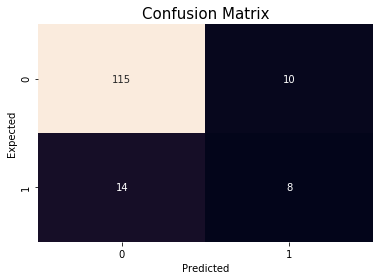

In [22]:
# Confusion Matrix
cm_plot =  pd.crosstab(index=y_test.values.ravel(), columns=y_test_pred, rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(cm_plot, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

### Observations of High Earners subset
Accuracy improved over the base model when using subsets of high earners. Training accuracy was 92% and testing accuracy was 87%.


### GridSearch CV Logistic Regression - for Low Earners

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_low, Y_low, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(588, 69) (588, 1)
(147, 69) (147, 1)


In [24]:
# Determine Best Estimator
params = dict(
    penalty = ['l1','l2'], #l1 lasso l2 ridge
    C = np.logspace(-3,3,7),
    solver=['lbfgs'],
    max_iter = [200,250,500,750]
)

# best_estimator = GridSearchCV(lr_clf, params,cv=10)
best_estimator = gridSearcBestEstimator(LogisticRegression(), params, cv)

# # Fit Model to best_estimator
lr_clf = fitModel(best_estimator)

# Calcualate Training and Testing Accuracy
y_test_pred = modelAccuracy(lr_clf)

# Print Confusion Matrix
cm = confusionMatrix(y_test, y_test_pred)

# Print Metrics
metrics(cm, y_test, y_test_pred)

Best Estimator:
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Training Accuracy:  0.9098639455782312
Testing Accuracy:   0.8571428571428571

                  Predicted Negative  Predicted Positive
Actual Negative                 116                   6
Actual Positive                  15                  10

Recall:                   0.4
Specificity:              0.9508196721311475
Precision:                0.625
Balanced Accuracy:        0.6754098360655738
F1-Score:                 0.48780487804878053


In [25]:
rows=(np.round(lr_clf.coef_,decimals=2) > 0.95).ravel()
print(X.columns[rows])

Index(['DistanceFromHome', 'MonthlyRate', 'NumCompaniesWorked',
       'StockOptionLevel', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'Education_Below College', 'EnvironmentSatisfaction_Low',
       'WorkLifeBalance_Bad', 'BusinessTravel_Travel_Frequently',
       'Department_Sales', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'MaritalStatus_Single',
       'OverTime_Yes'],
      dtype='object')


### Confusion Matrix for Best Estimator - Low Earners

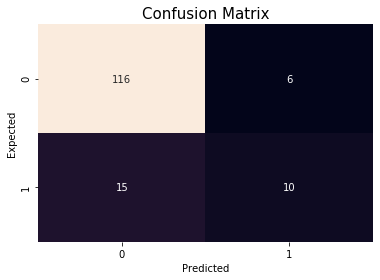

In [26]:
# Confusion Matrix
cm_plot =  pd.crosstab(index=y_test.values.ravel(), columns=y_test_pred, rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(cm_plot, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

### Observations of Low Earners subset
Testing accuracy was lower than the base model when running the model on Low Earners. Training accuracy was 91% and testing accuracy was 83%.


### Running model for Male vs Female Employees

In [27]:
# Use Median to create split for high/low variable
X_male = X.loc[X['Gender_Male'] == 1]
Y_male = Y.loc[X['Gender_Male'] == 1]
X_female = X.loc[X['Gender_Female'] == 1]
Y_female = Y.loc[X['Gender_Female'] == 1]

In [28]:
print(Y_low.shape)
print(X_low.shape)
print(Y_high.shape)
print(X_high.shape)

(735, 1)
(735, 69)
(735, 1)
(735, 69)


### GridSearch CV Logistic Regression - for male employees

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_male, Y_male, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(705, 69) (705, 1)
(177, 69) (177, 1)


In [30]:
# Determine Best Estimator
params = dict(
    penalty = ['l1','l2'], #l1 lasso l2 ridge
    C = np.logspace(-3,3,7),
    solver=['lbfgs'],
    max_iter = [200,250,500,750]
)

# best_estimator = GridSearchCV(lr_clf, params,cv=10)
best_estimator = gridSearcBestEstimator(LogisticRegression(), params, cv)

# # Fit Model to best_estimator
lr_clf = fitModel(best_estimator)

# Calcualate Training and Testing Accuracy
y_test_pred = modelAccuracy(lr_clf)

# Print Confusion Matrix
cm = confusionMatrix(y_test, y_test_pred)

# Print Metrics
metrics(cm, y_test, y_test_pred)

Best Estimator:
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Training Accuracy:  0.8921985815602836
Testing Accuracy:   0.8361581920903954

                  Predicted Negative  Predicted Positive
Actual Negative                 135                  10
Actual Positive                  19                  13

Recall:                   0.40625
Specificity:              0.9310344827586207
Precision:                0.5652173913043478
Balanced Accuracy:        0.6686422413793103
F1-Score:                 0.4727272727272727


In [31]:
rows=(np.round(lr_clf.coef_,decimals=2) > 0.95).ravel()
print(X.columns[rows])

Index(['DistanceFromHome', 'NumCompaniesWorked', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'JobInvolvement_Low', 'WorkLifeBalance_Bad',
       'JobRole_Human Resources', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'OverTime_Yes'],
      dtype='object')


### Confusion Matrix for Best Estimator - Male Employees

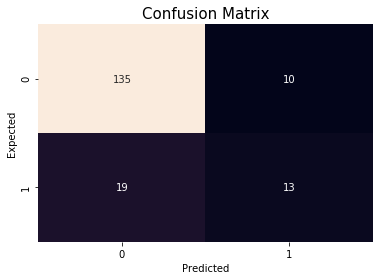

In [32]:
# Confusion Matrix
cm_plot =  pd.crosstab(index=y_test.values.ravel(), columns=y_test_pred, rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(cm_plot, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

### Observations of Male subset
Using the subset of male employees only, training accuracy was 90% and testing accuracy was 81%, which is not as good of accuracy as the base model, or splitting by earning type.

### GridSearch CV Logistic Regression - for Female Employees

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_female, Y_female, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(470, 69) (470, 1)
(118, 69) (118, 1)


In [34]:
# Determine Best Estimator
params = dict(
    penalty = ['l1','l2'], #l1 lasso l2 ridge
    C = np.logspace(-3,3,7),
    solver=['lbfgs'],
    max_iter = [200,250,500,750]
)

# best_estimator = GridSearchCV(lr_clf, params,cv=10)
best_estimator = gridSearcBestEstimator(LogisticRegression(), params, cv)

# # Fit Model to best_estimator
lr_clf = fitModel(best_estimator)

# Calcualate Training and Testing Accuracy
y_test_pred = modelAccuracy(lr_clf)

# Print Confusion Matrix
cm = confusionMatrix(y_test, y_test_pred)

# Print Metrics
metrics(cm, y_test, y_test_pred)

Best Estimator:
LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 

Training Accuracy:  0.9170212765957447
Testing Accuracy:   0.8305084745762712

                  Predicted Negative  Predicted Positive
Actual Negative                  92                  12
Actual Positive                   8                   6

Recall:                   0.42857142857142855
Specificity:              0.8846153846153846
Precision:                0.3333333333333333
Balanced Accuracy:        0.6565934065934066
F1-Score:                 0.375


/Users/kara/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/kara/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_m

In [35]:
rows=(np.round(lr_clf.coef_,decimals=2) > 0.95).ravel()
print(X.columns[rows])

Index(['DistanceFromHome', 'PercentSalaryHike', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'Education_Doctor',
       'EnvironmentSatisfaction_Low', 'JobInvolvement_Low',
       'JobSatisfaction_Low', 'RelationshipSatisfaction_Low',
       'BusinessTravel_Travel_Frequently', 'Department_Sales',
       'EducationField_Human Resources', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'MaritalStatus_Single',
       'OverTime_Yes'],
      dtype='object')


The above shows the top predictors for female attrition, including 'DistanceFromHome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'Education_Doctor',
       'JobInvolvement_Low', 'RelationshipSatisfaction_Low',
       'BusinessTravel_Travel_Frequently', 'EducationField_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Sales Representative',
       'MaritalStatus_Single', 'OverTime_Yes

#### Confusion Matrix for Best Estimator - Female Employees

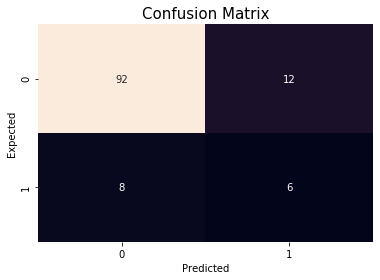

In [36]:
# Confusion Matrix
cm_plot =  pd.crosstab(index=y_test.values.ravel(), columns=y_test_pred, rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(cm_plot, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

### Observations of Female Employee subset
Best testing accuracy! Testing accuracy was 90% and training accuracy 92%. 


For logistic regression, the model with full training and testing data performed at 90% training accuracy and 85% testing accuracy. In order to improve accuracy and examine subsets of data, I performed a grid search on high/low earners, as well as male/female splits. 

The high earners model performed at 92% training accuracy and 87% testing accuracy, which is an improvement over the base model! 

The model for low earners did not perform as well. Training accuracy was 91% and testing accuracy was 83%. 

Using the subset of male employees only, training accuracy was 90% and testing accuracy was 81%, which is not as good of accuracy as the base model, or splitting by earning type.

Splitting the data for only female employees and running logistic regression yielded the highest accuracy. Training accuracy was 92% and testing accuracy 90%. 